# Modeling spherical bubbles in fluid channel

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

A model of spherical bubbles in the flud channel is created.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def plot_setup(labels=['X', 'Y'], fsize=18, title='', size=None):
    """Creates a custom plot configuration to make graphs look nice.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)

def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

## Get image list

Get list of all images which we will model.

In [2]:
# set path of folder which contains image files
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

model_info = np.load(data_path, allow_pickle=True)[()]
model_info['num_of_bubbles_to_try'] = 200000

## Model the void fraction in each channel image

Now we use Monte Carlo methods to construct possible bubble configurations
in the channel which will approximate the experimentally-measured
void fraction in each image. This is carried out by beginning
with a uniform simulated channel of void fraction = 0 and incrementally
adding bubbles of stochastic positions and radii until the
void fraction in the modeled channel is equal to the void fraction
in the measured image within an error threshold.

First we import the trimmed channel images from the dictionary file.
Then we loop over each image, construct an empty simulated channel, and
incrementally add bubbles to it. When the simulated channel matches the
image, we stop and move to the next image.

THe simulated channel models are saved to file in the *\models* directory.
Each model is saved as a Python dictionary and corresponds
to a particular channel image. The model includes:
* **label**: (filename) of the original channel image
* **img_model**: simulated channel image
* **img_voidfrac**: measured void fraction image
* **cent**: the centers of the simulated bubbles, in ordered pairs (x, y)
* **rad**: the radii of the simulated bubbles
* **percent_error**: total percent error between the measured channel image and the simulated channel image

In [3]:
def get_channel(channel_shape):
    """Return list of all index coordinates of the empty channel."""
    # get list of ordered pairs of channel index coordinates
    yy_channel, xx_channel = np.indices(channel_shape)
    channel_coords = np.column_stack(
        (np.ravel(xx_channel), np.ravel(yy_channel)))
    return channel_coords

def get_bubbles(model_info, channel):
    """Get random bubble radii and center coordinates."""
    # get number of bubbles and radii limits
    num = model_info['num_of_bubbles_to_try']
    min_rad = model_info['min_rad_um']/model_info['um_per_pixel'],
    max_rad = model_info['max_rad_um']/model_info['um_per_pixel']
    # get random radii and sort from large to small
    rad_list = np.random.uniform(min_rad, max_rad, num)
    rad_list = np.clip(rad_list, min_rad, max_rad)
    rad_list = np.sort(rad_list)[::-1]
    # get random x- and y-positions within the channel
    x_list = np.random.uniform(0, len(channel[0]), num)
    y_list = np.random.uniform(0, len(channel), num)
    return {
        'rad': rad_list,
        'rad_squared': np.square(rad_list),
        'x': x_list,
        'y': y_list}

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


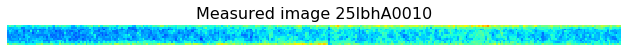

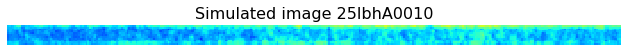

bubbles in channel: 11001
total runtime (min): 0.6
simulation error (%): 7.31
--------------------------------------------------------------



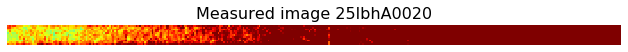

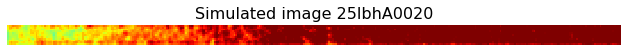

bubbles in channel: 10261
total runtime (min): 1.3
simulation error (%): 3.52
--------------------------------------------------------------



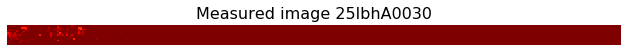

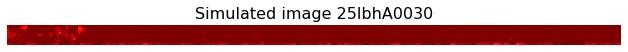

bubbles in channel: 8396
total runtime (min): 2.0
simulation error (%): 1.85
--------------------------------------------------------------



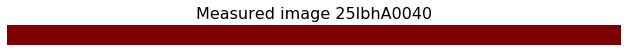

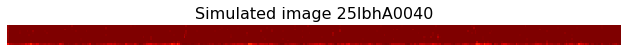

bubbles in channel: 8310
total runtime (min): 2.6
simulation error (%): 1.83
--------------------------------------------------------------



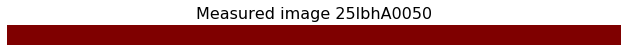

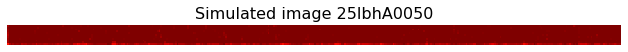

bubbles in channel: 8331
total runtime (min): 3.2
simulation error (%): 1.84
--------------------------------------------------------------



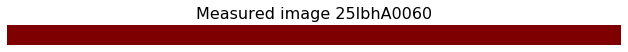

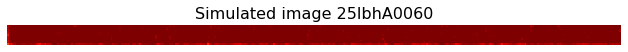

bubbles in channel: 8276
total runtime (min): 3.7
simulation error (%): 1.82
--------------------------------------------------------------



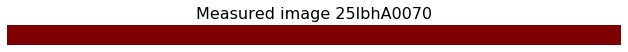

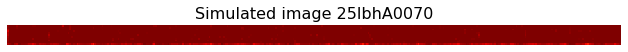

bubbles in channel: 8350
total runtime (min): 4.3
simulation error (%): 1.82
--------------------------------------------------------------



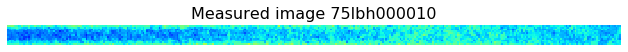

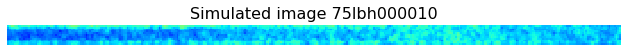

bubbles in channel: 10144
total runtime (min): 4.9
simulation error (%): 6.5
--------------------------------------------------------------



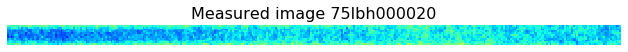

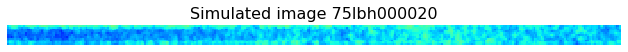

bubbles in channel: 10473
total runtime (min): 5.4
simulation error (%): 6.48
--------------------------------------------------------------



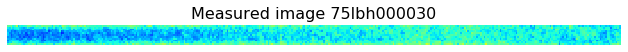

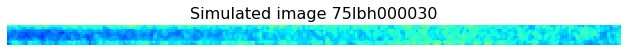

bubbles in channel: 10411
total runtime (min): 6.0
simulation error (%): 6.33
--------------------------------------------------------------



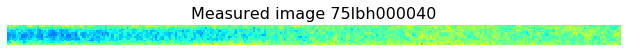

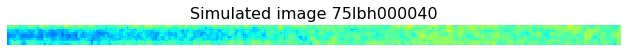

bubbles in channel: 11021
total runtime (min): 6.5
simulation error (%): 6.17
--------------------------------------------------------------



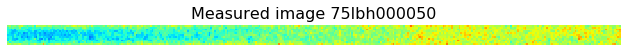

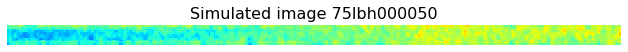

bubbles in channel: 11061
total runtime (min): 7.1
simulation error (%): 6.0
--------------------------------------------------------------



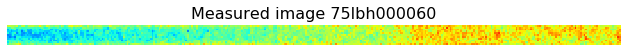

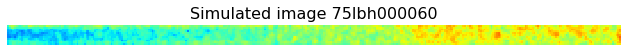

bubbles in channel: 11122
total runtime (min): 7.7
simulation error (%): 5.87
--------------------------------------------------------------



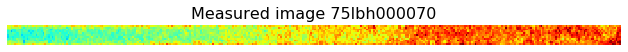

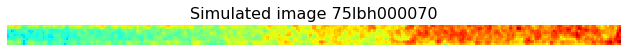

bubbles in channel: 11594
total runtime (min): 8.3
simulation error (%): 5.67
--------------------------------------------------------------



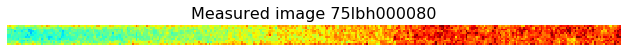

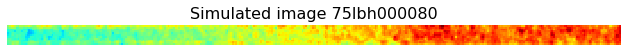

bubbles in channel: 11344
total runtime (min): 8.8
simulation error (%): 5.48
--------------------------------------------------------------



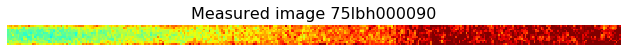

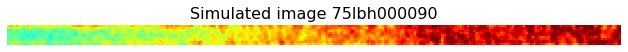

bubbles in channel: 11627
total runtime (min): 9.4
simulation error (%): 5.07
--------------------------------------------------------------



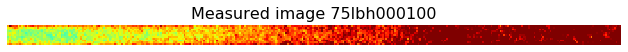

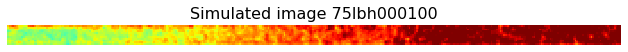

bubbles in channel: 11231
total runtime (min): 9.9
simulation error (%): 4.47
--------------------------------------------------------------



In [4]:
starttime = time()

# loop over each image
for L in list(model_info['channels']):

    # get target image to model
    measured_image = model_info['channels'][L]['img_voidfrac']

    # get list of channel index coordinates and potential bubbles
    channel_coords = get_channel(measured_image.shape)
    bub_dict = get_bubbles(model_info, measured_image)

    # simulate empty channel to populate with simulated bubbles
    sim = {
        'label': L,
        'flowrate': model_info['channels'][L]['flowrate'],
        'temp': model_info['channels'][L]['temp'],
        'img_model': np.zeros_like(measured_image),
        'img_voidfrac': measured_image,
        'cent': [],
        'rad': []}
    
    # pixels to add to each bubble as a fluid buffer
    buffer_pixels = model_info['buffer_um']/model_info['um_per_pixel']
    
    # loop over each bubble to try and fit into the channel
    for i in range(len(bub_dict['rad'])):

        # get z-profile of new bubble
        bub_profile = 2*np.sqrt(bub_dict['rad_squared'][i]
                                - np.square(channel_coords[:, 0]-bub_dict['x'][i])
                                - np.square(channel_coords[:, 1]-bub_dict['y'][i])) + buffer_pixels


        # convert nan to 0 and reshape to channel size
        bub_profile = np.where(np.isnan(bub_profile),
                               0, bub_profile).reshape(sim['img_model'].shape)


        # add new bubble to channel if it will fit
        if np.all(sim['img_model'] + bub_profile <= 1.02*sim['img_voidfrac']):
            sim['img_model'] += bub_profile
            sim['rad'].append(bub_dict['rad'][i])
            sim['cent'].append([bub_dict['x'][i], bub_dict['y'][i]])


    # get total avg error between image and model
    tot_err = np.mean(np.abs((sim['img_model']-sim['img_voidfrac'])/sim['img_voidfrac']))*100
    sim['percent_error'] = round(tot_err, 2)
    
    # save model to file on local machine
    save_model_path = os.path.join(os.getcwd(), 'spheres', 'models', L + '__model.npy')
    np.save(save_model_path, sim)
    
    # show original channel image
    plot_channel_image(sim['img_voidfrac'], title='Measured image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # show simulated channel image
    plot_channel_image(sim['img_model'], title='Simulated image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # print statistics of model
    print('bubbles in channel: {}'.format(len(sim['rad'])))
    print('total runtime (min): {}'.format(round((time() - starttime)/60,1)))
    print('simulation error (%): {}'.format(round(tot_err, 2)))
    print('--------------------------------------------------------------\n')